In [1]:
## personal imports
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
from datetime import datetime
from fund.fund import Fund
from pricer.pricer import Pricer as pricer_list
from ranker.ranker import Ranker as ranker_list
from classifier.classifier import Classifier as classifier_list
from portfolio.aportfolio import APortfolio

from analysis.quarterly_analysis import QuarterlyAnalysis as quarterly_analysis
from analysis.weekly_analysis import WeeklyAnalysis as weekly_analysis

## risk and return class imports
from returns.products import Products as returns_products_class

from fund.fund import Fund
## standard imports
from statistics import variance
import math
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
backtest_start_date = datetime(2016,1,1)
backtest_end_date  = datetime(2023,1,1)
current_start_date = datetime(2023,1,1)

In [3]:
market = Market()

In [4]:
portfolio = APortfolio(pricer_list.QUARTERLY_STOCK_FINANCIAL
                       ,classifier_list.QUARTERLY_STOCK_FINANCIAL_CLASSIFIER
                       ,ranker_list.QUARTERLY_STOCK_EARNINGS_RANKER)
portfolio_ii = APortfolio(pricer_list.WEEKLY_STOCK_SPECULATION
                          ,classifier_list.WEEKLY_STOCK_SPECULATION_CLASSIFIER
                          ,ranker_list.WEEKLY_STOCK_ROLLING_RANKER)
portfolio_iii = APortfolio(pricer_list.WEEKLY_STOCK_ROLLING
                           ,classifier_list.WEEKLY_STOCK_SPECULATION_CLASSIFIER
                          ,ranker_list.WEEKLY_STOCK_ROLLING_RANKER)
portfolio_iv = APortfolio(pricer_list.WEEKLY_STOCK_WINDOW
                          ,classifier_list.WEEKLY_STOCK_SPECULATION_CLASSIFIER
                          ,ranker_list.WEEKLY_STOCK_ROLLING_RANKER)
portfolios = []
# portfolios.append(portfolio)
portfolios.append(portfolio_ii)
portfolios.append(portfolio_iii)
portfolios.append(portfolio_iv)
fund = Fund(portfolios,backtest_start_date,backtest_end_date,current_start_date)
fund.initialize_portfolios()

In [5]:
market.connect()
sp500 = market.retrieve("sp500")
market.disconnect()
sp500 = sp500.rename(columns={"Symbol":"ticker"})

In [6]:
tyields = returns_products_class.tyields()
bench_returns = returns_products_class.spy_bench()

In [7]:
trades = []
for portfolio in fund.portfolios:
    portfolio.db.connect()
    trade = portfolio.db.retrieve("historical_trades")
    trade["positions"] = portfolio.pricer_class.positions
    trade["portfolio"] = portfolio.name
    trade["pricer_timeframe"] = portfolio.pricer_class.time_horizon_class.naming_convention
    trades.append(trade)
    portfolio.db.disconnect()

In [8]:
t = pd.concat(trades)
t = t[t["year"]>=backtest_start_date.year]

In [9]:
t

,year,week,ticker,weekly_delta,weekly_delta_sign,short_returns,returns,position,actual_returns,value,...,classification,rank,short,market_return,buy_day,sell_day,risk,positions,portfolio,pricer_timeframe
0,2016,5,PKG,0.042472,1.0,0.988826,0.985689,0,0.985689,True,...,False,False,False,1.15,0,1,True,20,wss_wssc_wsrr_b_r,week
1,2016,6,CTRA,0.064859,1.0,0.966061,0.976099,0,0.976099,True,...,False,False,False,1.15,0,1,True,20,wss_wssc_wsrr_b_r,week
2,2016,8,FCX,0.132181,1.0,0.970996,0.952081,0,0.952081,True,...,False,False,False,1.15,0,1,True,20,wss_wssc_wsrr_b_r,week
3,2016,9,FCX,0.121776,1.0,1.221494,1.027523,0,1.027523,True,...,False,False,False,1.15,0,1,True,20,wss_wssc_wsrr_b_r,week
4,2016,10,WMB,0.161914,1.0,0.895642,0.991081,0,0.991081,True,...,False,False,False,1.15,0,1,True,20,wss_wssc_wsrr_b_r,week
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159975,2022,48,JNPR,0.084520,1.0,0.987827,0.987827,19,0.987827,True,...,False,False,False,1.15,4,5,True,20,wsw_wssc_wsrr_b_r,week
159976,2022,49,INCY,0.072286,1.0,0.995628,0.992227,19,0.992227,True,...,False,False,False,1.15,4,5,True,20,wsw_wssc_wsrr_b_r,week
159977,2022,50,DUK,0.031685,1.0,1.013554,1.014750,19,1.014750,True,...,False,False,False,1.15,4,5,True,20,wsw_wssc_wsrr_b_r,week
159978,2022,51,LEN,0.032996,1.0,0.990179,1.011808,19,1.011808,True,...,False,False,False,1.15,4,5,True,20,wsw_wssc_wsrr_b_r,week


In [10]:
nonindex_columns = [
"year"
,"quarter"
,"week"
,"ticker"
,"quarterly_delta_sign"
,"quarterly_delta"
,"weekly_delta_sign"
,"weekly_delta"
,"short_returns"
,"returns"
,"floored_returns"
,"actual_returns"
,"position"
,"projected_quarterly_return"
,"positions"] 

In [11]:
indexers = []
indexer = []
for col in t.columns:
    if col not in nonindex_columns:
        indexers.append(list(t[col].unique()))
        indexer.append(col)
stuff = t[indexer].to_dict("records")
parameters = [dict(t) for t in {tuple(d.items()) for d in stuff}]

In [12]:
indexer

['value',
 'ceiling',
 'classification',
 'rank',
 'short',
 'market_return',
 'buy_day',
 'sell_day',
 'risk',
 'portfolio',
 'pricer_timeframe']

In [61]:
analysis = []
for parameter in tqdm(parameters):
    try:
        ledger = t.sort_values(["year",parameter["pricer_timeframe"]]).copy()
        for key in parameter.keys():
            ledger = ledger[ledger[key]==parameter[key]]
        positions = int(int(ledger["positions"].mean()) / 2)
        anas = weekly_analysis if parameter["pricer_timeframe"] == "week" else quarterly_analysis
        if ledger.index.size > 0:
            cumulative = anas.trade_analysis(indexer,ledger,positions,parameter,tyields,bench_returns)
            analysis.append(cumulative[indexer + ["pv","beta","rrr","sharpe"]].iloc[-1])
    except Exception as e:
        print(str(e))
        continue
a = pd.DataFrame(analysis)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:43<00:00,  1.73it/s]


In [62]:
a.sort_values("pv",ascending=False).head(20)

,value,ceiling,classification,rank,short,market_return,buy_day,sell_day,risk,portfolio,pricer_timeframe,pv,beta,rrr,sharpe
334,True,True,False,False,False,1.15,1,5,True,wsr_wssc_wsrr_b_r,week,4.925713,0.078939,1.080890,49.718792
328,True,True,False,False,False,1.15,3,3,True,wsw_wssc_wsrr_b_r,week,4.169801,0.170450,1.173550,18.590979
332,True,True,False,False,False,1.15,2,5,True,wsr_wssc_wsrr_b_r,week,4.084379,0.099981,1.102197,30.839946
333,True,True,False,False,False,1.15,1,5,True,wsw_wssc_wsrr_b_r,week,3.952120,0.034926,1.036325,84.498417
328,True,True,False,False,False,1.15,3,4,True,wsr_wssc_wsrr_b_r,week,3.686190,0.146007,1.148800,18.391065
328,True,True,False,False,False,1.15,3,3,True,wsr_wssc_wsrr_b_r,week,3.456982,0.142939,1.145693,17.182355
332,True,True,False,False,False,1.15,2,4,True,wsr_wssc_wsrr_b_r,week,3.060565,0.110488,1.112835,18.641008
332,True,True,False,False,False,1.15,2,4,True,wss_wssc_wsrr_b_r,week,3.060009,0.084659,1.086683,24.321534
334,True,True,False,False,False,1.15,1,5,True,wss_wssc_wsrr_b_r,week,2.927234,0.031618,1.032976,60.922848
334,True,True,False,False,False,1.15,1,4,True,wsr_wssc_wsrr_b_r,week,2.914554,0.045252,1.046781,42.287107


In [63]:
a.sort_values("pv",ascending=False).groupby("portfolio").nth(0).reset_index()

,portfolio,value,ceiling,classification,rank,short,market_return,buy_day,sell_day,risk,pricer_timeframe,pv,beta,rrr,sharpe
0,wsr_wssc_wsrr_b_r,True,True,False,False,False,1.15,1,5,True,week,4.925713,0.078939,1.080890,49.718792
1,wss_wssc_wsrr_b_r,True,True,False,False,False,1.15,2,4,True,week,3.060009,0.084659,1.086683,24.321534
2,wsw_wssc_wsrr_b_r,True,True,False,False,False,1.15,3,3,True,week,4.169801,0.170450,1.173550,18.590979


In [64]:
top = a[a["portfolio"]=="wss_wssc_wsrr_b_r"].sort_values("pv",ascending=False).iloc[0]
anas = weekly_analysis if top["pricer_timeframe"] == "week" else quarterly_analysis
analysis = t
for key in parameter.keys():
    analysis = analysis[(analysis[key]==top[key])]
naming = top["pricer_timeframe"]
ledger = analysis[["year",naming,"ticker",f"{naming}ly_delta",f"{naming}ly_delta_sign","actual_returns","position"]]
ledger = ledger[ledger["year"]>=backtest_start_date.year]
ledger = ledger.merge(sp500[["ticker","GICS Sector","Security"]],on="ticker",how="left")

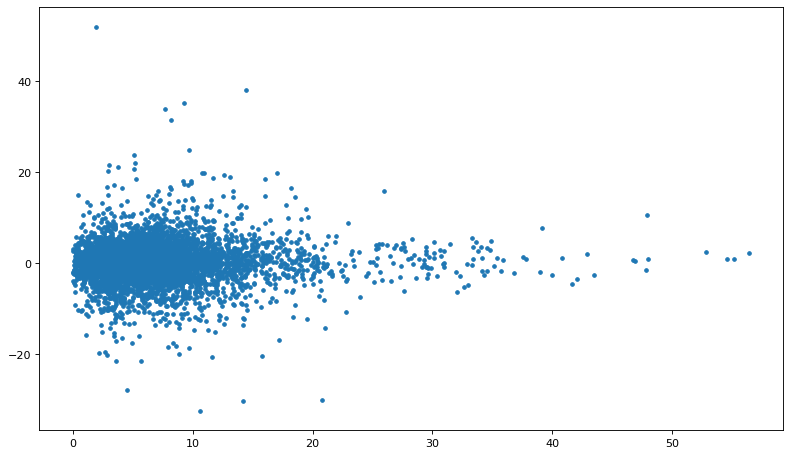

In [65]:
plt.figure(figsize=(12, 7), dpi=80)
plt.scatter(ledger[f"{naming}ly_delta"] * 100, (ledger["actual_returns"]-1)*100,s=10)

In [66]:
ledger.sort_values(["year",naming,"position"],ascending=True).head(20)

,year,week,ticker,weekly_delta,weekly_delta_sign,actual_returns,position,GICS Sector,Security
0,2016,5,BSX,0.032936,1.0,0.926114,0,Health Care,Boston Scientific
333,2016,5,PKG,0.024822,1.0,0.993727,1,Materials,Packaging Corporation of America
665,2016,5,SRE,0.023394,1.0,0.990694,2,Utilities,Sempra Energy
997,2016,5,CPB,0.019478,1.0,0.990407,3,Consumer Staples,Campbell Soup Company
1329,2016,5,TFX,0.017596,1.0,0.963119,4,Health Care,Teleflex
1661,2016,5,LMT,0.003150,1.0,1.000939,5,Industrials,Lockheed Martin
1,2016,6,NVR,0.138346,1.0,0.997369,0,Consumer Discretionary,"NVR, Inc."
334,2016,6,GILD,0.023320,1.0,1.037472,1,Health Care,Gilead Sciences
666,2016,6,PG,0.022213,1.0,1.000368,2,Consumer Staples,Procter & Gamble
998,2016,6,AFL,0.021098,1.0,1.029453,3,Financials,Aflac


In [67]:
ledger["actual_returns"].mean()

1.002914546528076

In [68]:
ledger[ledger["actual_returns"]>1].index.size / ledger.index.size

0.5592649310872895

In [69]:
portfolio = ledger.pivot_table(index=["year",naming],columns="position",values="actual_returns").fillna(1).reset_index()

In [70]:
portfolio

position,year,week,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
0,2016,5,0.926114,0.993727,0.990694,0.990407,0.963119,1.000939,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,2016,6,0.997369,1.037472,1.000368,1.029453,1.035203,1.058214,1.029633,0.982785,...,1.071033,1.105824,1.004979,1.043120,1.008706,1.030655,1.056710,1.002933,1.000000,1.000000
2,2016,7,1.052702,1.044077,0.997541,1.012168,0.998991,1.015213,1.003366,1.016192,...,1.052347,1.022945,1.003023,1.006078,0.961400,0.929248,1.013176,1.020180,0.955579,1.021486
3,2016,8,1.059997,0.888921,1.026589,1.015330,1.079440,1.013287,0.992516,1.070506,...,1.044757,1.137318,0.952341,1.026111,0.991632,0.987510,1.024224,1.022596,0.995709,0.996676
4,2016,9,1.044593,0.986653,1.054692,0.987998,1.009112,0.985306,1.026443,1.010743,...,1.042221,1.026966,0.978846,0.989574,1.013200,1.013007,0.963000,1.021936,1.000804,0.990913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,2022,48,1.007273,0.989704,1.013964,0.986870,0.990762,1.009427,0.967000,1.027612,...,0.983322,0.976838,0.907869,1.019641,0.980115,1.005067,1.041411,0.977434,0.968029,0.932663
329,2022,49,1.045735,1.027893,1.054251,1.072400,1.047476,1.032683,1.029670,1.063859,...,1.021921,1.028551,1.017641,0.996675,1.085623,1.015410,1.041599,1.028537,1.042848,1.032672
330,2022,50,0.907354,0.872300,0.904523,0.908906,0.907014,0.891070,0.974840,0.926329,...,0.932014,0.899878,0.911558,0.954066,0.958603,0.929495,0.922801,0.956989,0.940334,0.962244
331,2022,51,1.004481,0.856980,1.001010,0.965918,1.011735,0.993732,1.012497,1.029834,...,1.010160,0.994969,0.979182,0.997326,1.018845,1.017606,0.994971,0.996706,1.019206,0.996634


In [71]:
cumulative = anas.iteration_analysis(portfolio,positions,bench_returns)

In [72]:
cumulative

,0,1,2,3,4,5,6,7,8,9,year,week,pv,adjclose,bench,date_string,date
0,0.926114,0.993727,0.990694,0.990407,0.963119,1.000939,1.000000,1.000000,1.000000,1.000000,2016,5,0.986500,189.76016,1.000000,2016-W5,2016-02-05
1,0.923677,1.030964,0.991058,1.019577,0.997024,1.059208,1.029633,0.982785,1.008784,1.016672,2016,6,1.005938,190.93200,1.006175,2016-W6,2016-02-12
2,0.972356,1.076406,0.988621,1.031983,0.996017,1.075321,1.033099,0.998698,1.074821,1.021071,2016,7,1.026839,185.12200,0.975558,2016-W7,2016-02-19
3,1.030695,0.956839,1.014907,1.047803,1.075141,1.089609,1.025367,1.069112,1.091124,1.022380,2016,8,1.042298,191.68750,1.010157,2016-W8,2016-02-26
4,1.076657,0.944068,1.070415,1.035227,1.084938,1.073598,1.052481,1.080598,1.083419,0.986196,2016,9,1.048760,194.18584,1.023322,2016-W9,2016-03-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,0.737385,4.433331,2.496269,3.877189,1.589543,4.197723,7.964537,2.295427,0.841870,2.565631,2022,48,3.099891,399.81000,2.106923,2022-W48,2022-12-02
329,0.771109,4.556990,2.631694,4.157896,1.665009,4.334916,8.200848,2.442011,0.830048,2.892116,2022,49,3.248264,402.62200,2.121741,2022-W49,2022-12-09
330,0.699669,3.975062,2.380426,3.779135,1.510186,3.862712,7.994518,2.262106,0.800591,2.620211,2022,50,2.988462,395.22000,2.082734,2022-W50,2022-12-16
331,0.702804,3.406547,2.382831,3.650336,1.527908,3.838502,8.094423,2.329593,0.809004,2.678249,2022,51,2.942020,394.64400,2.079699,2022-W51,2022-12-23


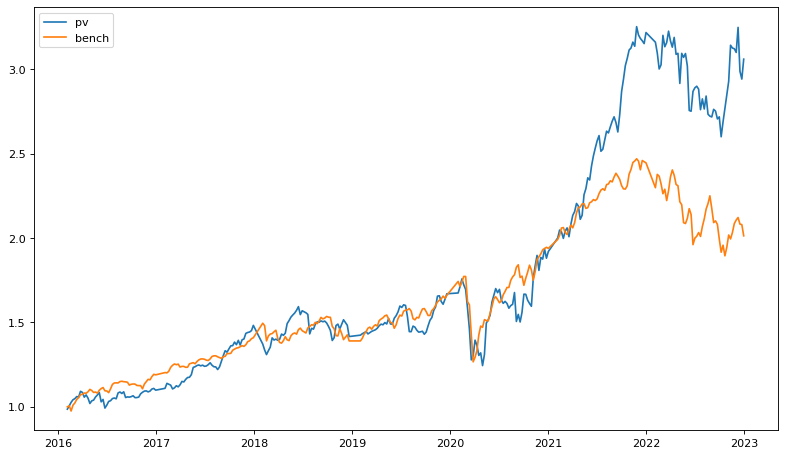

In [73]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])
plt.plot(cumulative["date"],cumulative["bench"])
plt.legend(["pv","bench"])

In [74]:
cumulative

,0,1,2,3,4,5,6,7,8,9,year,week,pv,adjclose,bench,date_string,date
0,0.926114,0.993727,0.990694,0.990407,0.963119,1.000939,1.000000,1.000000,1.000000,1.000000,2016,5,0.986500,189.76016,1.000000,2016-W5,2016-02-05
1,0.923677,1.030964,0.991058,1.019577,0.997024,1.059208,1.029633,0.982785,1.008784,1.016672,2016,6,1.005938,190.93200,1.006175,2016-W6,2016-02-12
2,0.972356,1.076406,0.988621,1.031983,0.996017,1.075321,1.033099,0.998698,1.074821,1.021071,2016,7,1.026839,185.12200,0.975558,2016-W7,2016-02-19
3,1.030695,0.956839,1.014907,1.047803,1.075141,1.089609,1.025367,1.069112,1.091124,1.022380,2016,8,1.042298,191.68750,1.010157,2016-W8,2016-02-26
4,1.076657,0.944068,1.070415,1.035227,1.084938,1.073598,1.052481,1.080598,1.083419,0.986196,2016,9,1.048760,194.18584,1.023322,2016-W9,2016-03-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,0.737385,4.433331,2.496269,3.877189,1.589543,4.197723,7.964537,2.295427,0.841870,2.565631,2022,48,3.099891,399.81000,2.106923,2022-W48,2022-12-02
329,0.771109,4.556990,2.631694,4.157896,1.665009,4.334916,8.200848,2.442011,0.830048,2.892116,2022,49,3.248264,402.62200,2.121741,2022-W49,2022-12-09
330,0.699669,3.975062,2.380426,3.779135,1.510186,3.862712,7.994518,2.262106,0.800591,2.620211,2022,50,2.988462,395.22000,2.082734,2022-W50,2022-12-16
331,0.702804,3.406547,2.382831,3.650336,1.527908,3.838502,8.094423,2.329593,0.809004,2.678249,2022,51,2.942020,394.64400,2.079699,2022-W51,2022-12-23


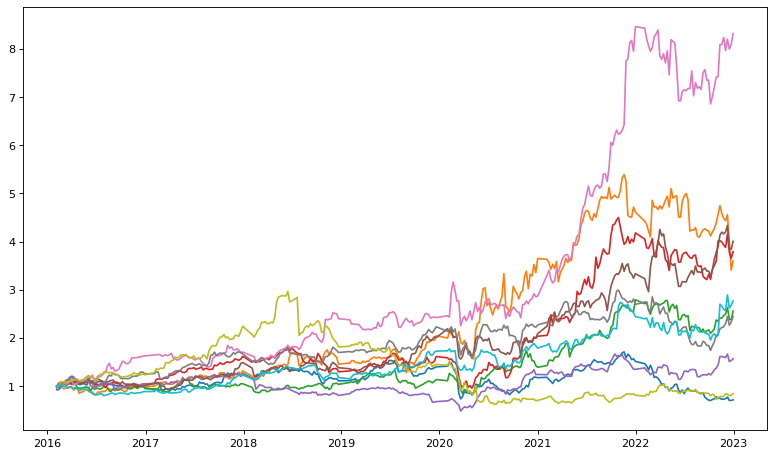

In [75]:
plt.figure(figsize=(12, 7), dpi=80)
position_columns = [x for x in cumulative.columns if x not in ["year","week","quarter","date_string","date","pv","adjclose","bench"]]
for i in position_columns:
    position = cumulative[i]
    plt.plot(cumulative["date"],position)

plt.show()


In [76]:
ledger.groupby(["GICS Sector"]).mean().sort_values("actual_returns",ascending=False)

,year,week,weekly_delta,weekly_delta_sign,actual_returns,position
GICS Sector,,,,,,
Energy,2019.017699,29.141593,0.067494,1.0,1.005533,9.046460
Real Estate,2018.832776,27.237458,0.047981,1.0,1.004680,10.518395
Consumer Staples,2019.213058,27.814433,0.043134,1.0,1.004603,10.635739
Information Technology,2018.896804,28.228311,0.064578,1.0,1.003981,9.491324
Materials,2019.106771,28.067708,0.061958,1.0,1.003914,10.075521
Health Care,2019.103234,28.531095,0.058926,1.0,1.003465,9.351990
Consumer Discretionary,2018.921540,28.783124,0.098727,1.0,1.002294,7.107328
Financials,2019.110507,29.769928,0.054685,1.0,1.001985,11.063406
Utilities,2018.880952,26.718254,0.044517,1.0,1.001896,11.063492


In [77]:
ledger.groupby(["year",naming,"ticker","Security"]).prod().sort_values("actual_returns",ascending=False).head(30)

weekly_delta  weekly_delta_sign  \
year week ticker Security                                                    
2020 5    TSLA   Tesla, Inc.                   0.018831                1.0   
     20   CZR    Caesars Entertainment         0.144691                1.0   
     15   TSLA   Tesla, Inc.                   0.092332                1.0   
     20   PENN   Penn National Gaming          0.077017                1.0   
2022 45   ETSY   Etsy                          0.081610                1.0   
2020 45   CMA    Comerica                      0.096677                1.0   
2017 31   SEDG   SolarEdge                     0.050777                1.0   
2018 34   AMD    AMD                           0.051909                1.0   
2021 43   ANET   Arista Networks               0.030149                1.0   
2020 7    DXCM   Dexcom                        0.037235                1.0   
2021 47   MRNA   Moderna                       0.050701                1.0   
2020 7    TSLA   Tesla, Inc.                   0.029019                1.0   
2018 44   ENPH   Enphase                       0.107218                1.0   
2020 23   DVN    Devon Energy                  0.109336                1.0   
     20   MRNA   Moderna                       0.170463                1.0   
     23   HAL    Halliburton                   0.125867                1.0   
     45   HBAN   Huntington National Bank      0.130652                1.0   
     40   ENPH   Enphase                       0.116389                1.0   
2022 9    OXY    Occidental Petroleum          0.160309                1.0   
2020 25   ENPH   Enphase                       0.052166                1.0   
     45   L      Loews Corporation             0.098587                1.0   
          MPC    Marathon Petroleum            0.092134                1.0   
2021 21   MRO    Marathon Oil                  0.098392                1.0   
2019 37   APA    APA Corporation               0.092792                1.0   
2022 8    IRM    Iron Mountain                 0.033768                1.0   
2020 20   PAYC   Paycom                        0.096346                1.0   
2022 45   MCHP   Microchip Technology          0.081059                1.0   
2020 44   BKR    Baker Hughes                  0.028327                1.0   
     35   TSLA   Tesla, Inc.                   0.181706                1.0   
2017 43   ALGN   Align Technology              0.041208                1.0   

                                           actual_returns  position  
year week ticker Security                                            
2020 5    TSLA   Tesla, Inc.                     1.519751        11  
     20   CZR    Caesars Entertainment           1.380671         1  
     15   TSLA   Tesla, Inc.                     1.351942        12  
     20   PENN   Penn National Gaming            1.339782        12  
2022 45   ETSY   Etsy                            1.313816         9  
2020 45   CMA    Comerica                        1.248167        12  
2017 31   SEDG   SolarEdge                       1.238512        10  
2018 34   AMD    AMD                             1.220574        13  
2021 43   ANET   Arista Networks                 1.215472         9  
2020 7    DXCM   Dexcom                          1.212439         6  
2021 47   MRNA   Moderna                         1.207067         6  
2020 7    TSLA   Tesla, Inc.                     1.203587        18  
2018 44   ENPH   Enphase                         1.198238         6  
2020 23   DVN    Devon Energy                    1.198083         2  
     20   MRNA   Moderna                         1.197760         0  
     23   HAL    Halliburton                     1.194190         1  
     45   HBAN   Huntington National Bank        1.190476         5  
     40   ENPH   Enphase                         1.187311         3  
2022 9    OXY    Occidental Petroleum            1.184825         1  
2020 25   ENPH   Enphase                         1.184426        16  
     4

In [78]:
industry_analysis = ledger.pivot_table(index=["year",naming],columns="GICS Sector",values="actual_returns").fillna(1).reset_index()
industry_analysis[[x for x in industry_analysis.columns if x != "sell_date"]].cumprod()

GICS Sector,year,week,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
0,2016,5,1.000000,1.000000,0.990407,1.000000,1.000000,0.944617,1.000939,1.000000,0.993727,1.000000,0.990694
1,4064256,30,1.008745,1.028358,1.019417,0.982785,1.029453,0.968879,1.028050,1.000000,0.993727,1.081267,0.990694
2,8193540096,210,1.011301,1.018491,1.019417,1.005334,1.029453,1.025950,1.073363,1.010394,0.993727,1.081267,0.990694
3,16518176833536,1680,1.037708,1.065733,0.970833,1.005334,1.029453,1.020201,1.082462,1.021302,0.993727,1.081267,0.990694
4,33300644496408576,15120,1.065691,1.054204,0.970833,1.005334,1.029453,1.012997,1.092325,1.033677,1.021262,1.058394,0.990694
...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,0,0,0.987946,1.799388,2.172201,4.236664,1.083476,1.910223,1.026917,3.754725,1.688496,1.520166,0.998003
329,0,0,1.017259,1.930338,2.237166,4.236664,1.145233,1.942156,1.052756,3.754725,1.760844,1.562568,1.027863
330,0,0,0.931251,1.769815,2.103683,4.236664,1.116419,1.811325,1.004399,3.422914,1.760844,1.441939,0.989055
331,0,0,0.938491,1.764517,2.150281,4.318013,1.124184,1.723893,0.970168,3.405697,1.760844,1.441939,0.989055
